<font size="6"> **DMBEM Project Gianluca**</font>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ZHAW-dm4bem-2023/reproducible-report-gianluca/HEAD)

# Introduction & Setup 

The building, of which parts are to be simulated, is located in Holzkirchen, Germany. It is part of a study by the University of Strathclyde Glasgow that deals with the energy modeling and performance of buildings. Experimental data was collected in 2013 to validate the computer-based models. In order to generate high-quality data, a second, identical house was built, which after comparison differed by less than 5% from the first so-called "Twin house".

This data is being used in this project to make a statement about the quality of the present model.  

All data used here was taken from the study: "Twin Houses Empirical Dataset: Experiment 1" (source: [Dataset]).

[Dataset]: https://pureportal.strath.ac.uk/en/datasets/twin-houses-empirical-dataset-experiment-1

## Building & Location 

The following pictures Fig. 1 & 2 show the setup, location and alignment of the twin houses.  

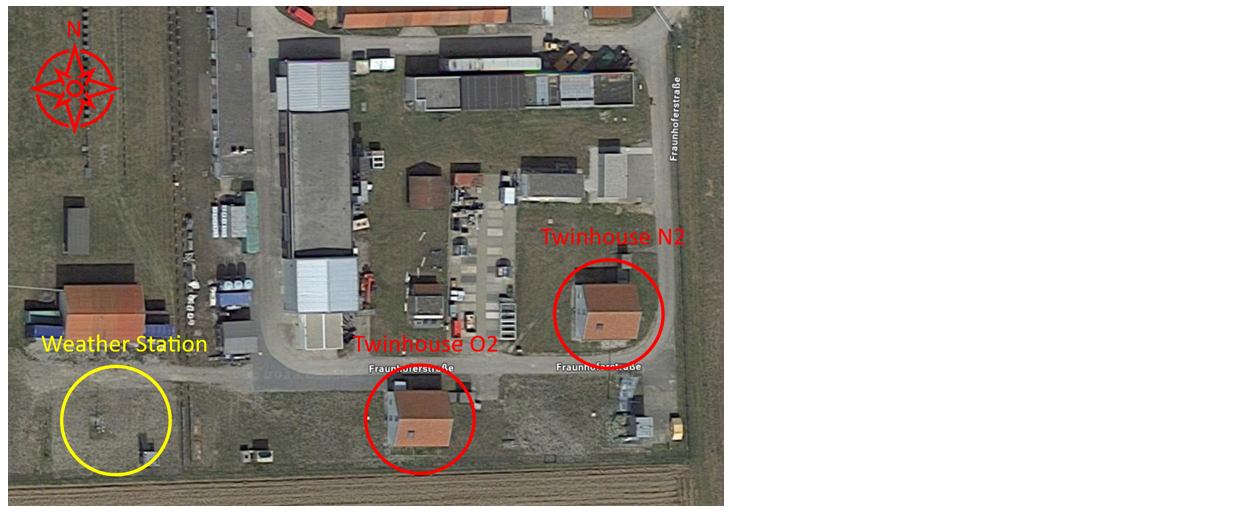
*Fig.1: The twin houses are located at [Holzkirchen] and are connected to a local weather station*

[Holzkirchen]: https://www.google.ch/maps/place/Fraunhofer-Institut+f%C3%BCr+Bauphysik+IBP/@47.8754298,11.7268692,322m/data=!3m1!1e3!4m6!3m5!1s0x479deddfcb23363b:0xd311a8c2b01ec930!8m2!3d47.8755984!4d11.7280582!16s%2Fg%2F1tf7r3ct?hl=de&entry=ttu

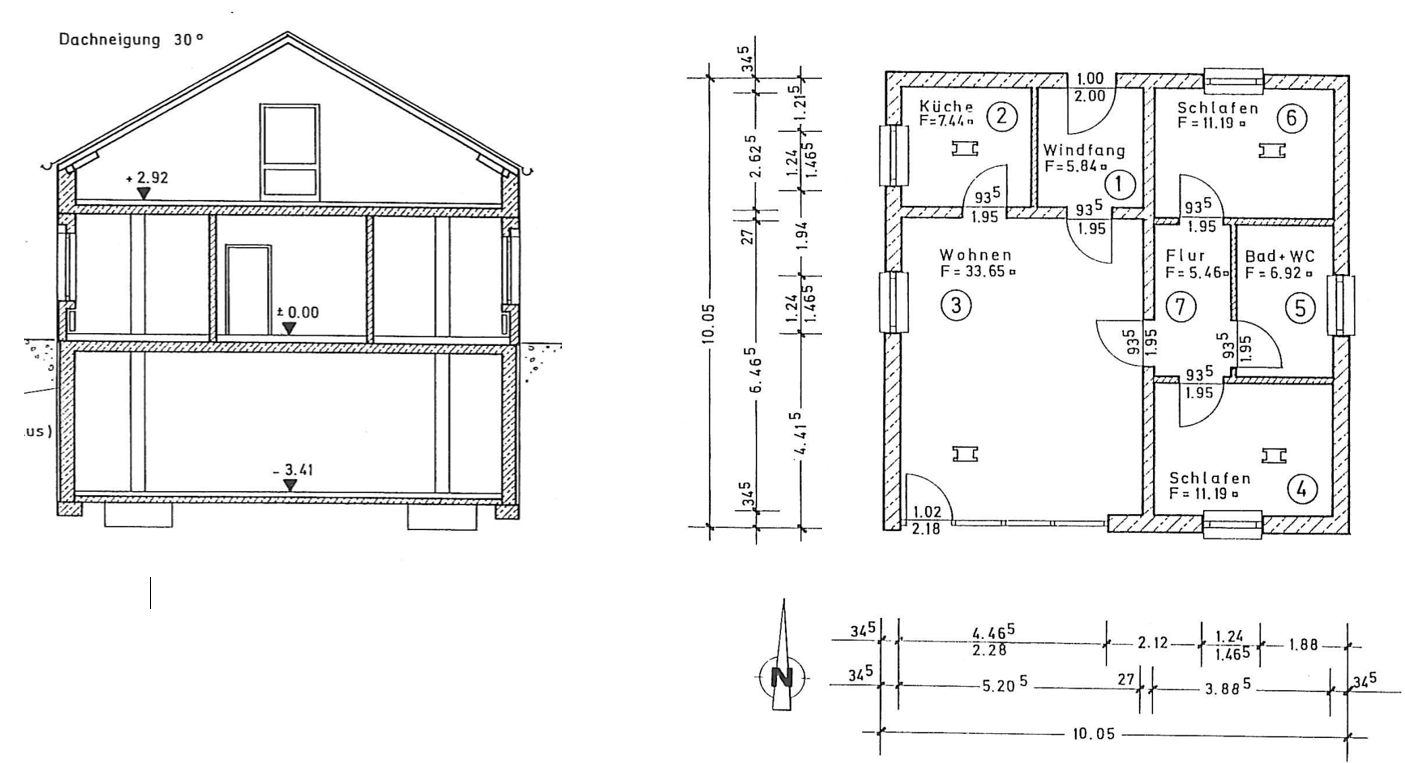
*Fig.2: Plan and Cross Section of the Twin House*

# Model 

## Model description

The model created in this project deals with the west wall of the twin house "N2". The input parameters were the air temperatures outside **To** and inside **Ti** as well as the total radiation from the west **Etot**. As output parameters, the surface temperatures outside **To_sur** and inside **Ti_sur** as well as a temperature inside the wall between different layers **T_BL** were defined. 

All the input and output parameters mentioned were chosen because they were collected during the 2013 measurements, making it possible to validate the model with the experimental data. 

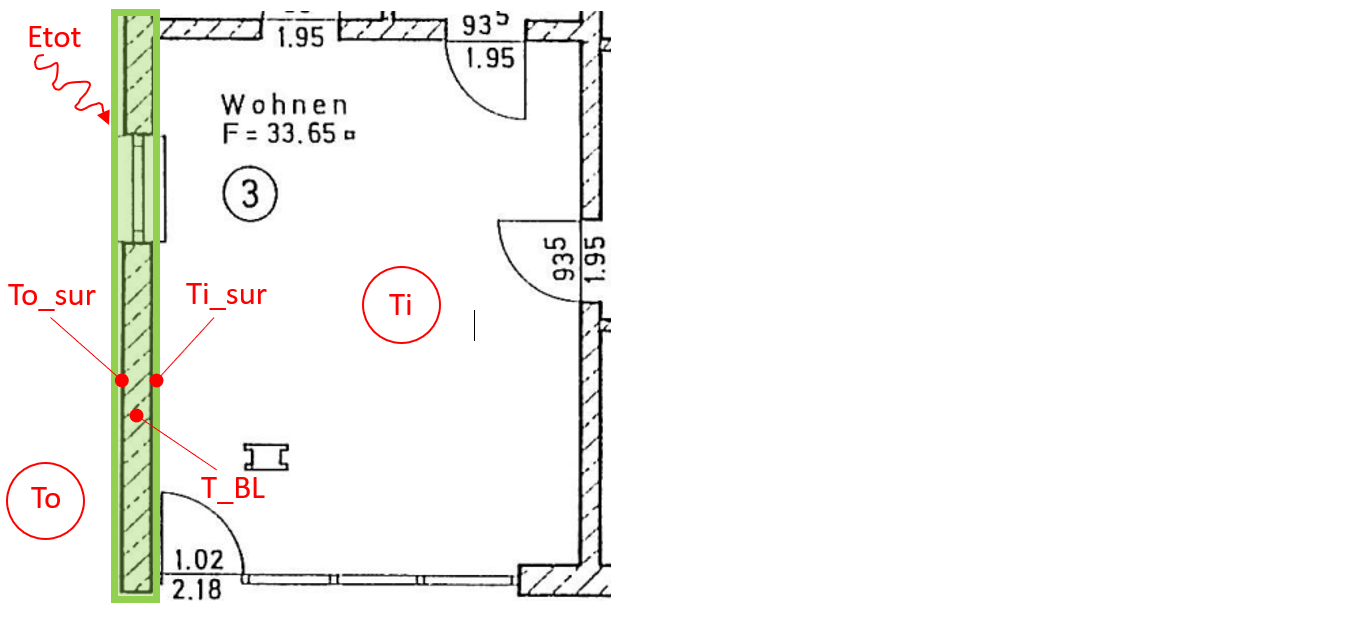
*Fig.3: The modeled wall with all input and output parameters is marked in green*.

## Thermal network  

The model described earlier is to be validated during a measurement period in which the window blinds are closed. For this reason, the wall has been simplified and the window has not been modeled. 
A further simplification involves the different layers of the wall. It was decided to limit the 5 original layers to two. This is because some layers are very thin and can therefore be neglected. Key characteristics of the neglected walls, such as absorption or emission coefficients, were transferred to the existing layers. 

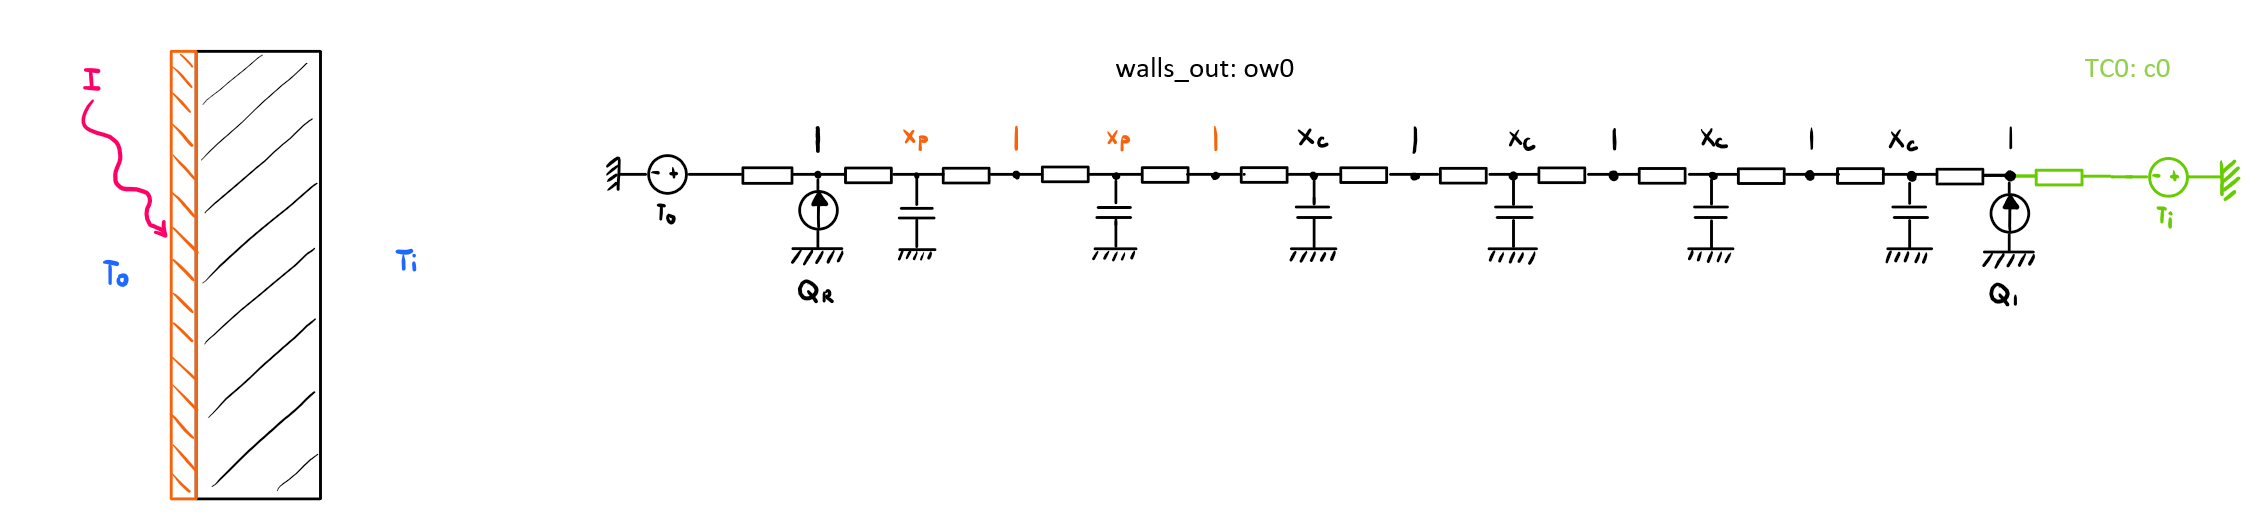
*Fig.4: Simplified wall with the according assembled thermal circuit. <span style="color:orange">Layer 1: Insulation</span> Layer 2: Honeycomb Brick*

The simplified wall can be seen on the left-hand side of Figure 4. The right-hand side shows the thermal circuit consisting of two individual TCs. These were put together with an assembly list.

It should be noted that the nodes shown here do not correspond to the model, as the model does have more nodes.

## Wall & Material characteristics 

### Wall characteristics

**Wall Area:** 14.33 m<sup>2</sup>

**Tilt angle:** 90 °

**<span style="color:orange">Insulation:</span>**

<span style="color:orange">- Conductivity: 0.04 (W/(m⋅K))</span>

<span style="color:orange">- Specific heat: 840 J/(kg⋅K)</span>

<span style="color:orange">- Density: 80 kg/m<sup>3</sup></span>

<span style="color:orange">- Width: 0.1 m</span>

<span style="color:orange">- Mesh: 16</span>


**Honeycomb Brick:**

- Conductivity: 0.22 (W/(m⋅K))

- Specific heat: 1000 J/(kg⋅K)

- Density: 800 kg/m<sup>3</sup>

- Width: 0.32 m

- Mesh: 56


### Material characteristics 

Convection coefficient on outer surface **h0**: 15 W/(m<sup>2</sup>⋅K)

Convection coefficient on inner surface **h1**: 8 W/(m<sup>2</sup>⋅K)

Short-wave absorbtion coefficient of outer surface **α0**: 0.17 

Long-wave hemispherical emissivity of outer surface **ε0**: 0.9 

The values for these properties were taken from Incropera et al. (2011) Fundamentals of heat and mass transfer, 7 ed, Table A3, and the Engineering Toolbox (https://www.engineeringtoolbox.com).


In [1]:
import pandas as pd
import dm4bem
import numpy as np
import matplotlib.pyplot as plt

In [1]:
Input_data = pd.read_csv('Input_Data.csv', index_col=0, usecols=['Index','To','Etot','Qi','Ti'], sep=';')

Validation_data = pd.read_csv('Validation_Data.csv', index_col=0, usecols=['Index','To_sur','To_sur_low','To_sur_high','Ti_sur','Ti_sur_low','Ti_sur_high','T_BL','T_BL_low','T_BL_high'], sep=';')

wall_types = pd.read_csv('wall_types.csv')

walls = pd.read_csv('walls_out.csv')

pd.DataFrame(walls)

pd.DataFrame(wall_types)

NameError: name 'pd' is not defined

## Thermal Circuit to State-Space representation

### DAE 

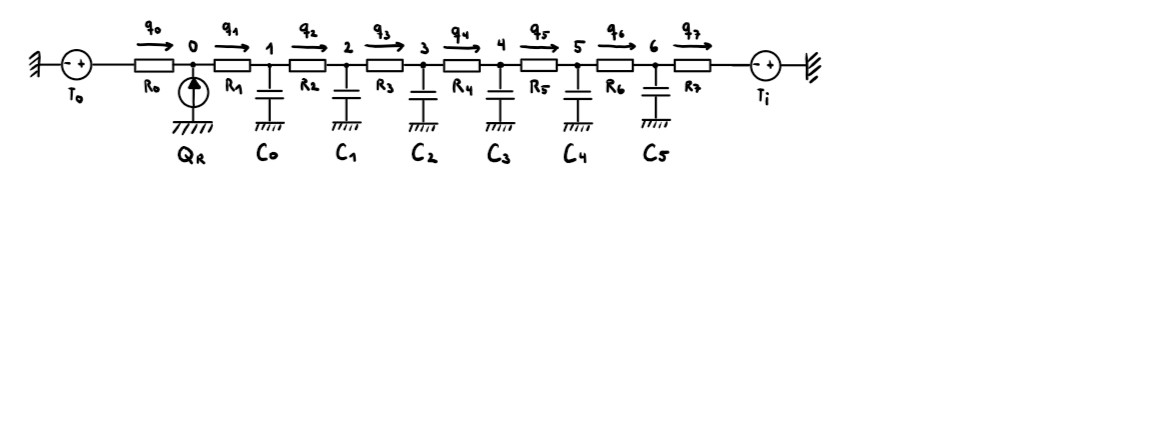
*Fig.5: Simplified TC for DAE*

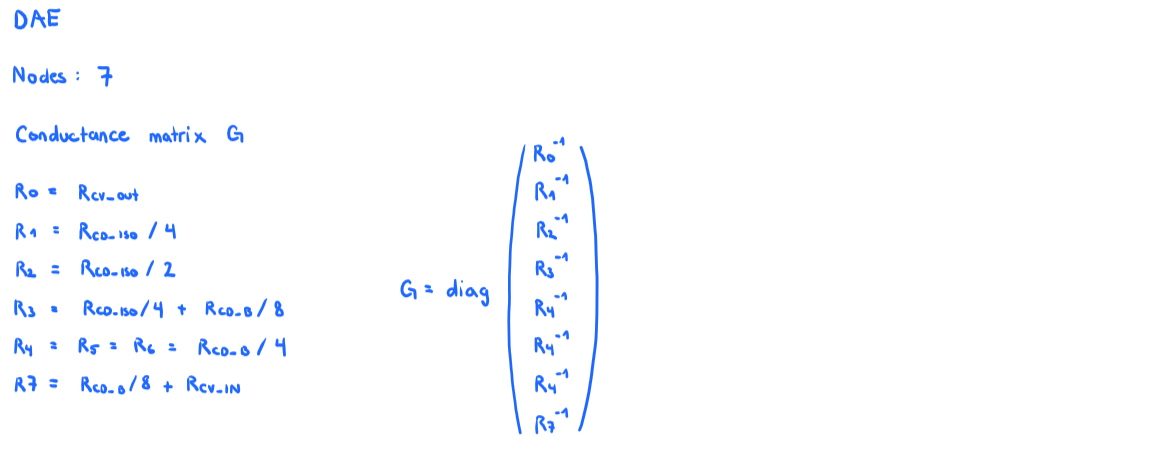
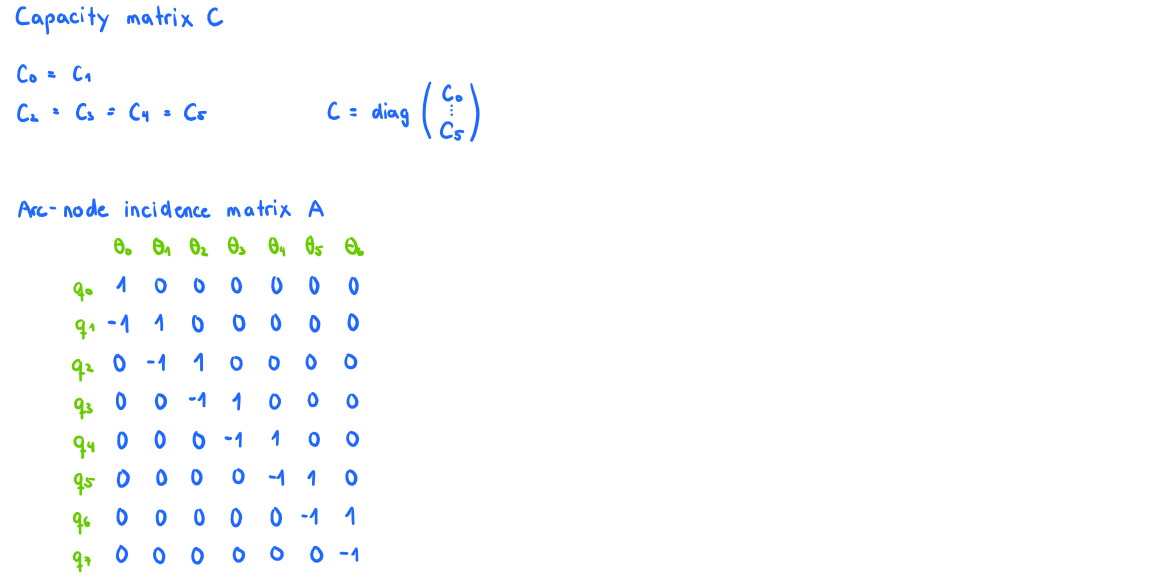

In [3]:
TCd = dm4bem.bldg2TCd('',
                      TC_auto_number=True)

ass_lists = pd.read_csv('assembly_lists.csv',sep=';')
ass_mat = dm4bem.assemble_lists2matrix(ass_lists)
TC = dm4bem.assemble_TCd_matrix(TCd, ass_mat)

# State-space from TC
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

### Time step & Settling Time

In [4]:
dtmax = 2 * min(-1. / λ) # max time step for Euler explicit stability
print(f'\nMaximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')
dt = dm4bem.round_time(dtmax)
dm4bem.print_rounded_time('dt', dt)
t_settle = 4 * max(-1. / λ)
# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)


Maximum time step: 33.01 s = 0.55 min
dt = 30 s
duration = 568800 s = 158.0 h


# Simulation 

## Steady State Solution 

<Axes: >

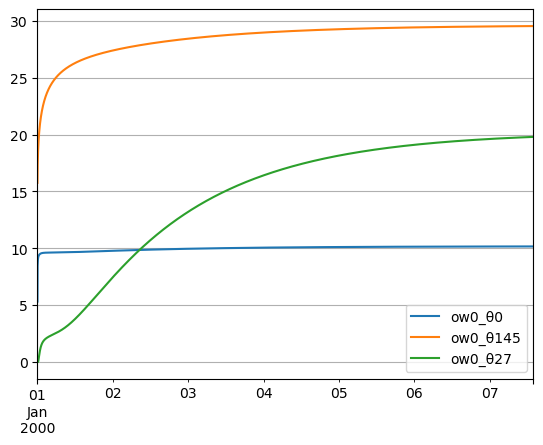

In [5]:
# Create input_data_set
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# Create a DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2000-01-01 00:00:00",
                     periods=n, freq=f"{int(dt)}S")

To_SS = Input_data.iloc[0]['To'] * np.ones(n)
Ti_SS = Input_data.iloc[0]['Ti'] * np.ones(n)
Qo_SS = Input_data.iloc[0]['Etot']*walls['α1'].values[0]*walls['Area'].values[0] * np.ones(n)
Qi_SS = 0* np.ones(n)

data_SS = {'To': To_SS, 'Ti': Ti_SS, 'Qo': Qo_SS, 'Qi': Qi_SS}
input_data_set_SS = pd.DataFrame(data_SS, index=time)

# Get input u from input_data_set
u_SS = dm4bem.inputs_in_time(us, input_data_set_SS)

# Initial conditions
θ0 = 0                      # initial temperatures
θ_exp = pd.DataFrame(index=u_SS.index)
θ_exp[As.columns] = θ0      # Fill θ with initial valeus θ0


I = np.eye(As.shape[0])     # identity matrix

for k in range(n - 1):
    θ_exp.iloc[k + 1] = (I + dt * As)\
        @ θ_exp.iloc[k] + dt * Bs @ u_SS.iloc[k]

        
# Outputs
y_SS = (Cs @ θ_exp.T + Ds @  u_SS.T).T

# Plot
y_SS.plot(kind='line', marker='', linestyle='-', label=['Explicit'], grid=True)

For the steady state solution, the first set of data from the experiment was used as input. The diagram above shows the corresponding temperatures of the outer and inner wall as well as the temperature in the wall between the different layers. 

## Transient solution with weather data

Input of To, Ti and E_tot all 10 mins. Als Initiallösung wurde die Lösung der Steady State Rechnungen verwendet. 

In [6]:
# Input
To = Input_data['To']
Ti = Input_data['Ti']

Etot = Input_data['Etot']
Qo = walls['α1'].values[0]*walls['Area'].values[0]*Etot
Qi = Input_data['Qi']


# Input data set
input_data_set = pd.DataFrame({'To': To, 'Qo': Qo, 'Ti': Ti,  'Qi': Qi})


# Get input from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)


# Initial conditions
θ0_trans = θ_exp.iloc[-1]                 # initial temperatures
θ_exp_trans = pd.DataFrame(index=u.index)
θ_exp_trans[As.columns] = θ0_trans      # Fill θ with initial valeus θ0

# time integration
I = np.eye(As.shape[0])     # identity matrix

for k in range(u.shape[0] - 1):
    θ_exp_trans.iloc[k + 1] = (I + dt * As)\
        @ θ_exp_trans.iloc[k] + dt * Bs @ u.iloc[k]

# Outputs
y = (Cs @ θ_exp_trans.T + Ds @  u.T).T

## Results

The first step was to carry out a grid independence study. The number of nodes was increased step by step to see how the output responded. This was done until no noticeable changes were observed. 

It was also ensured that the distances between the nodes were kept constant across all layers so that no abrupt changes in length were caused in the grid. 

Independence was found at around 72 nodes with a total wall thickness of 0.42 m. 

### Outer Surface 

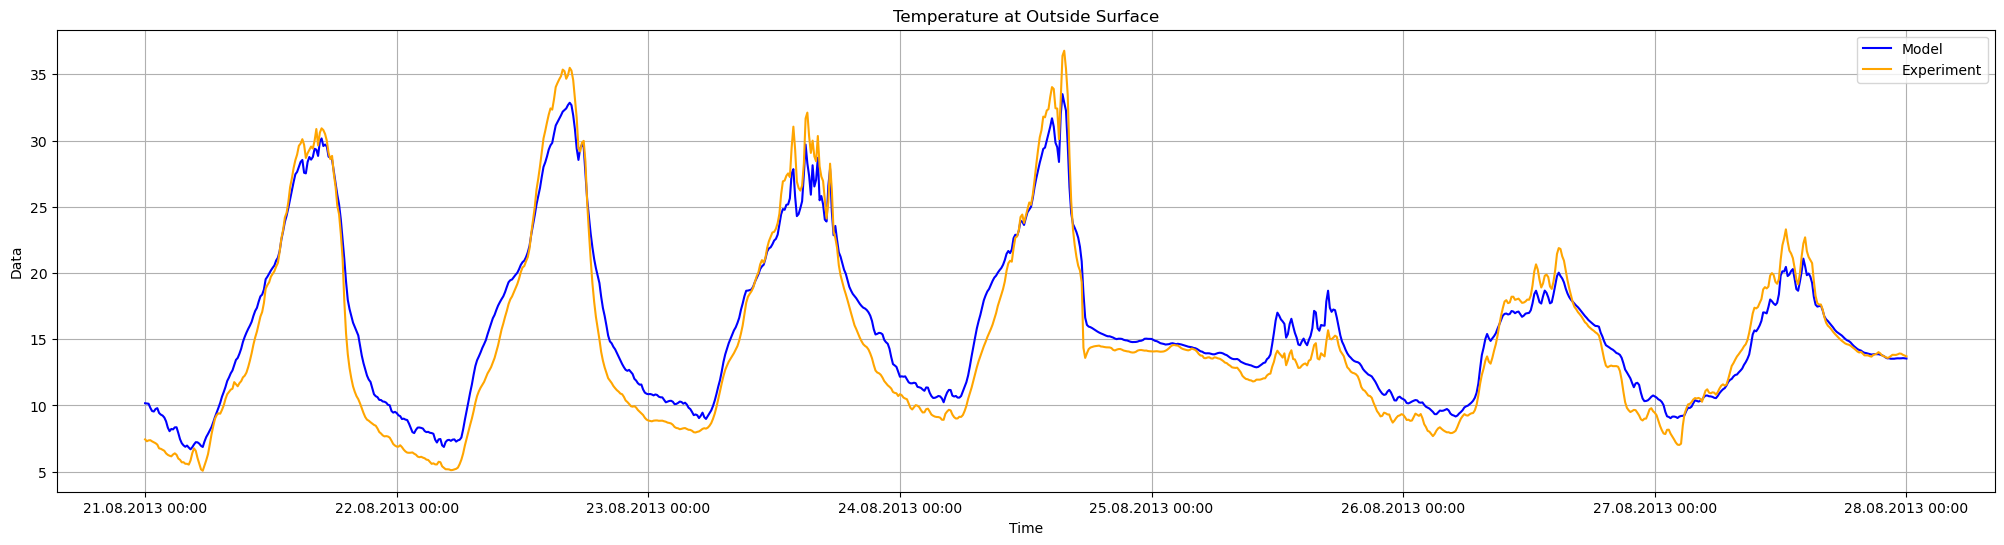

In [11]:
# Plot
data = pd.DataFrame({'Model': y['ow0_θ0'],
                     'Experiment': Validation_data['To_sur']})

fig, ax = plt.subplots(figsize=(25,6))
ax.plot(data.index, data['Model'], label='Model', color='blue')
ax.plot(data.index, data['Experiment'], label='Experiment',color='orange')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Data')
ax.set_title('Temperature at Outside Surface')
ax.set_xticks(data.index[::144])
ax.grid(True)

It can be seen that the outer wall temperature of the model agrees quite well with the data from the experiment. 

### Inner Surface 

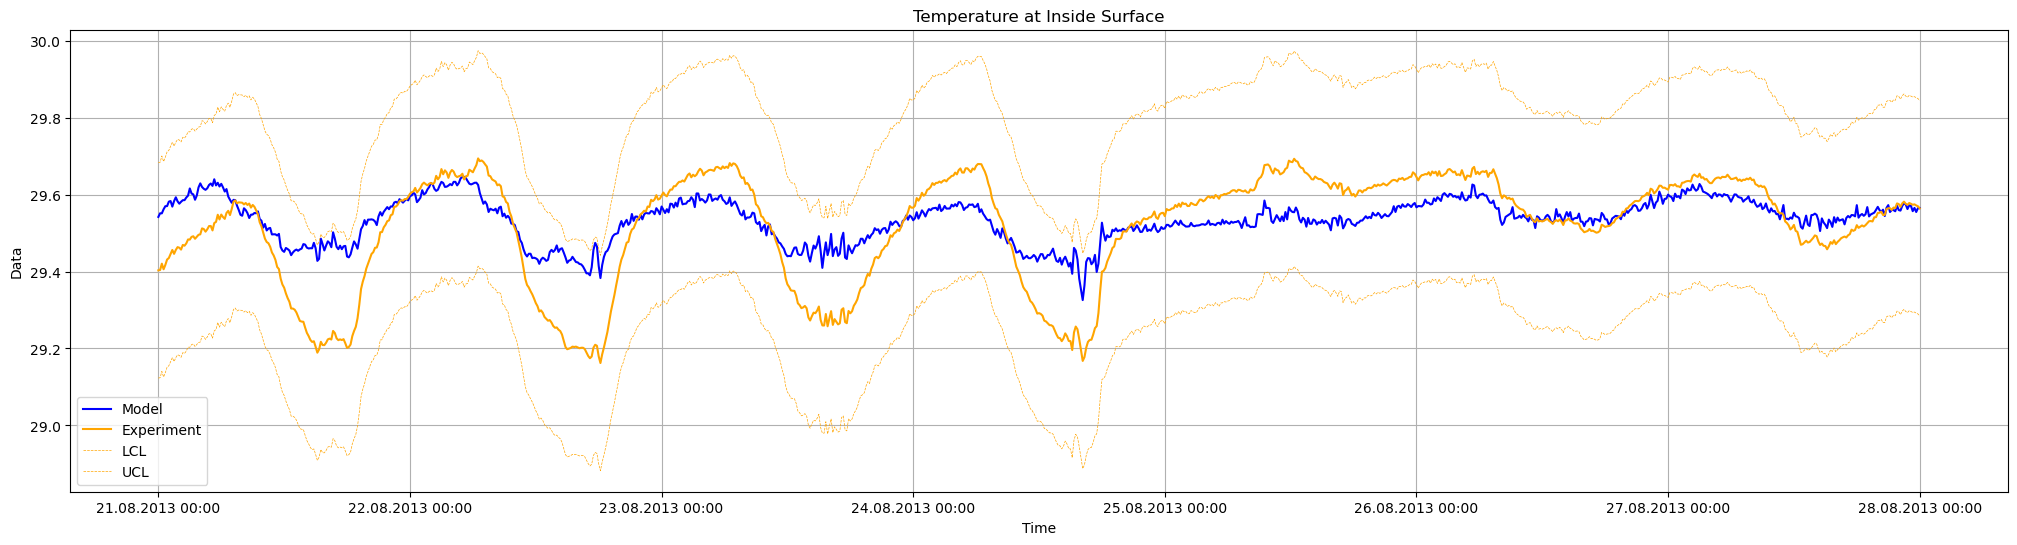

In [13]:
# Plot
data = pd.DataFrame({'Model': y['ow0_θ145'],
                     'Experiment': Validation_data['Ti_sur'],
                     'LCL': Validation_data['Ti_sur_low'],
                     'UCL': Validation_data['Ti_sur_high']})

fig, ax = plt.subplots(figsize=(25,6))
ax.plot(data.index, data['Model'], label='Model', color='blue')
ax.plot(data.index, data['Experiment'], label='Experiment',color='orange')
ax.plot(data.index, data['LCL'], label = 'LCL', linestyle='--', color='orange', lw=0.5)
ax.plot(data.index, data['UCL'], label = 'UCL', linestyle='--',color='orange', lw=0.5)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Data')
ax.set_title('Temperature at Inside Surface')
ax.set_xticks(data.index[::144])
ax.grid(True)

The model and experiment also agree well for the inner wall temperature. The model is within the uncertainty limits resulting from the uncertainty of the sensors. 

### Between Layer 

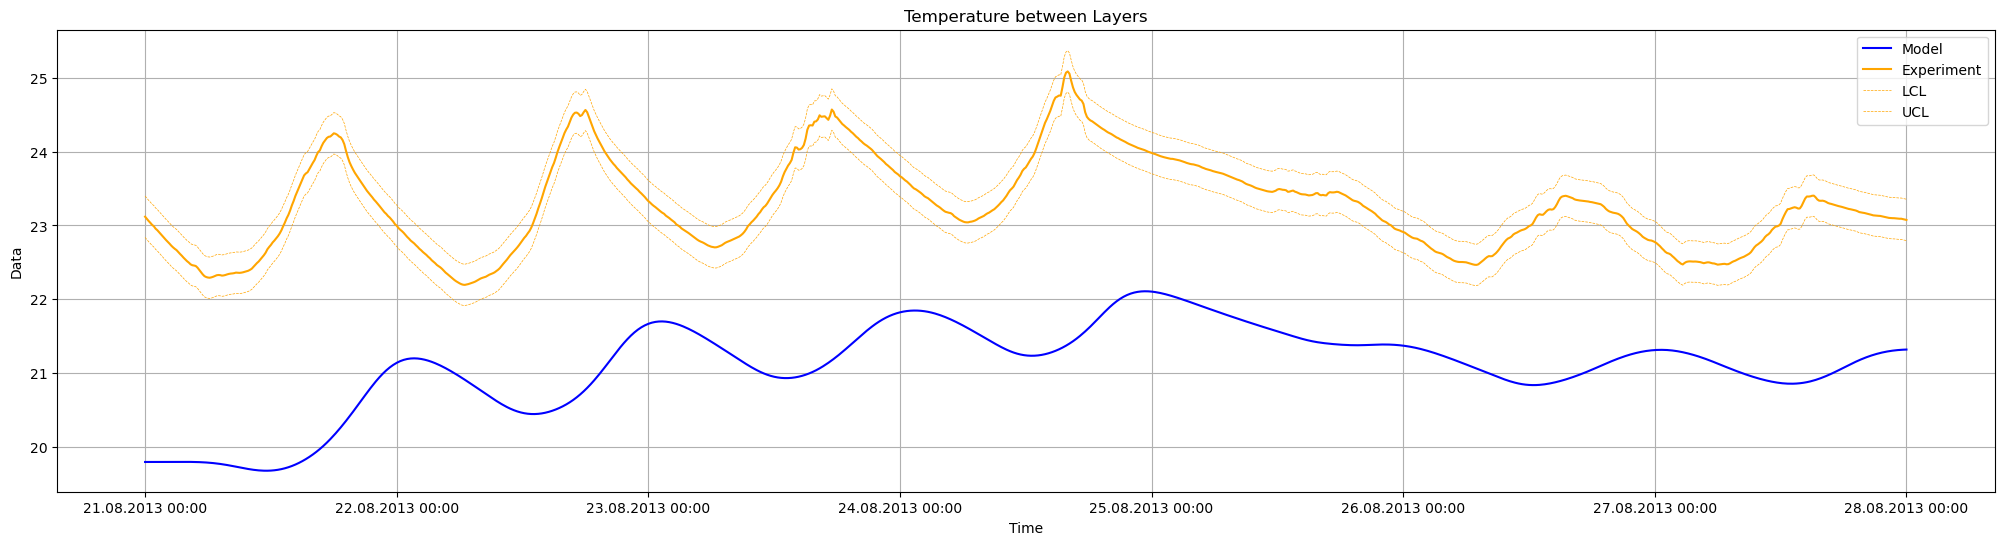

In [9]:
# Plot
data = pd.DataFrame({'Model': y['ow0_θ27'],
                     'Experiment': Validation_data['T_BL'],
                     'LCL': Validation_data['T_BL_low'],
                     'UCL': Validation_data['T_BL_high']})

fig, ax = plt.subplots(figsize=(25,6))
ax.plot(data.index, data['Model'], label='Model', color='blue')
ax.plot(data.index, data['Experiment'], label='Experiment',color='orange')
ax.plot(data.index, data['LCL'], label = 'LCL', linestyle='--',color='orange',lw=0.5)
ax.plot(data.index, data['UCL'], label = 'UCL', linestyle='--',color='orange',lw=0.5)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Data')
ax.set_title('Temperature between Layers')
ax.set_xticks(data.index[::144])
ax.grid(True)

There was no good agreement between the model and the experiment for the temperature in the wall between different layers. 

In the documentation of the experiments, it was not precisely defined between which layer the sensor was located, nor at which position (length) it was installed.

It is therefore difficult to make a qualitative statement as to why a temperature difference was found here. 

## Conclusion



It can be said that a simple model of a wall can be modelled relatively well using the selected methods. It has been shown that both wall temperatures can be predicted well by the model. 

It must be said that some adjustments had to be made to the estimated parameters in order to achieve good agreement. 

It was already a relatively large effort for one wall to obtain a good agreement with the experiment. Some things were simplified and neglected and many things had to be checked and revised. Nevertheless, with the necessary additional effort, it is possible to simulate an entire house with the methods used. 